## Markov chains for `striplog`

Initially based on [Alfredo Molina on Medium](https://medium.com/@__amol__/markov-chains-with-python-1109663f3678), then incorporating quasi-independence model from Powers & Easterling, https://doi.org/10.1306/212F808F-2B24-11D7-8648000102C1865D. 

Need to define some functions and a `Markov_chain` class.

## Parse states

All of the Markov chain code I could find wanted a transition matrix as input. But I wanted to be able to provide a sequence, then get the transitions from it. So we need to be able to parse a sequence of states &mdash; tokens representing the items in the sequence we are modeling. 

For example, we need the unique elements and 'sequence of sequences' from:

- A list of states, eg `[10, 20, 10, 20, 20, 10]`
- A string of states, eg `'ABBDDDDDCCCC'`
- A list of lists of states, eg `[[1,2,2,3], [2,4,2]]`  (NB, not same length)
- A list of strings of states, eg `['aaabb', 'aabbccc']` (NB, not same length)
- A list of state names, eg `['sst', 'mud', 'sst']` (requires optional argument)
- A list of lists of state names, eg `[['SS', 'M', 'SS'], ['M', 'M', 'LS']]`

The uniques should look like:

- `[10, 20]`
- `['A', 'B', 'C', 'D']`
- `[1, 2, 3, 4]`
- `['a', 'b', 'c']`
- `['mud', sst']`
- `['LS', 'M', 'SS']`

And the sequences of sequences:

- `[10, 20, 10, 20, 20, 10]`
- `['A', 'B', 'B', 'D', 'D', 'D', 'D', 'D', 'C', 'C', 'C', 'C']`
- `[[1,2,2,3], [2,4,2]]`
- `[['a', 'a', 'a', 'b', 'b'], ['a', 'a', 'b', 'b', 'c', 'c', 'c']]`
- `[['sst', 'mud', 'sst']]`
- `[['SS', 'M', 'SS'], ['M', 'M', 'LS']]`

For some reason, this turned out to be a bit fiddly...

In [1]:
import numpy as np

def regularize(sequence, strings_are_states=False) -> tuple:
    """
    Turn a sequence or sequence of sequences into a tuple of
    the unique elements in the sequence(s), plus a sequence
    of sequences (sort of equivalent to `np.atleast_2d()`).
    
    Args
        sequence (list-like): A list-like container of either
            states, or of list-likes of states.
        strings_are_states (bool): True if the strings are
            themselves states (i.e. words or tokens) and not
            sequences of one-character states. For example,
            set to True if you provide something like:
            
                ['sst', 'mud', 'mud', 'sst', 'lst', 'lst']
                
    Returns
        tuple. A tuple of the unique states, and a sequence
            of sequences.
    """
    if strings_are_states:
        if isinstance(sequence[0], str):
            seq_of_seqs = [sequence]
        else:
            seq_of_seqs = sequence
    else:
        # Just try to iterate over the contents of the sequence.
        try:
            seq_of_seqs = [list(i) if len(i) > 1 else i for i in sequence]
        except TypeError:
            seq_of_seqs = [list(sequence)]

        # Annoyingly, still have to fix case of single sequence of
        # strings... this seems really hacky.
        if len(seq_of_seqs[0]) == 1:
            seq_of_seqs = [seq_of_seqs]

    # Now we know we have a sequence of sequences.
    uniques = set()
    for seq in seq_of_seqs:
        for i in seq:
            uniques.add(i)

    return np.array(sorted(uniques)), seq_of_seqs

assert regularize([1,2,3,4,4,5,6])[1] == [[1, 2, 3, 4, 4, 5, 6]]
assert regularize([[1,2,3,4], [4,5,6]])[1] == [[1, 2, 3, 4], [4, 5, 6]]
assert regularize(['ssmm', 'mml'])[1] == [['s', 's', 'm', 'm'], ['m', 'm', 'l']]
assert regularize('ssmmlll')[1] == [['s', 's', 'm', 'm', 'l', 'l', 'l']]
assert regularize(['sand', 'mud'], strings_are_words=True)[1] == [['sand', 'mud']]
assert regularize([['sand', 'mud'], ['mud', 'mud']], strings_are_words=True)[1] == [['sand', 'mud'],['mud', 'mud']]

## A `Markov_chain` class

In [2]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt


def hollow_matrix(M):
    """
    Return hollow matrix (zeros on diagonal).
    
    Args
        M (ndarray): a 2D, square array representing a matrix.
        
    Returns
        ndarray. The same array with zeros on the diagonal.
    """
    return (1 - np.eye(M.shape[0])) * M


class Markov_chain(object):
    """
    Markov_chain object.
    
    TODO
    - Integrate into `striplog` or move into own project.
    - Pretty transition matrix printing with state names and row/col sums.
    - Allow self-transitions.
    - Allow other step sizes (especially 2 and 3).
    - Hidden Markov model?
    - More generally, explore other sequence models, eg LSTM.
    """
    
    def __init__(self, transition_counts, states=None):
        """
        Initialize the MarkovChain instance.
 
        Args
            transition_counts (ndarray): A 2-D array representing the counts
                of change of state in the Markov Chain.
            states (array-like): An array-like representing the possible states
                of the Markov Chain. Must be in the same order as `transition_counts`.
        """
        self.transition_counts = np.atleast_2d(transition_counts)

        if states is not None:        
            self.states = np.asarray(states)
        elif self.transition_counts is not None:
            self.states = np.arange(self.transition_counts.shape[0])
        else:
            self.states = None
                    
        self.expected_counts = self._compute_expected()
            
        return
        
    def __repr__(self):
        return f"Markov_chain({np.sum(self.transition_counts)} transitions, states={self.states})"

    @staticmethod
    def _compute_freqs(C):
        """
        Compute frequencies from counts.
        """
        epsilon = 1e-12
        return (C.T / (epsilon+np.sum(C.T, axis=0))).T
    
    @staticmethod
    def _stop_iter(a, b, tol=0.01):
        a_small = np.all(np.abs(a[-1] - a[-2]) < tol*a[-1])
        b_small = np.all(np.abs(b[-1] - b[-2]) < tol*b[-1])
        return (a_small and b_small)
    
    @property
    def _index_dict(self):
        if self.states is None:
            return {}
        return {self.states[index]: index for index in range(len(self.states))}
    
    @property
    def _state_dict(self):
        if self.states is None:
            return {}
        return {index: self.states[index] for index in range(len(self.states))}
    
    @property
    def transition_freqs(self):
        return self._compute_freqs(self.transition_counts)
    
    @property
    def expected_freqs(self):
        return self._compute_freqs(self.expected_counts)
    
    @property
    def _state_counts(self):
        a = np.sum(m.transition_counts, axis=0)
        b = np.sum(m.transition_counts, axis=1)
        return np.maximum(a, b)
 
    @property
    def _state_probs(self):
        return self._state_counts / np.sum(self._state_counts)
    
    @property
    def normalized_difference(self):
        O = self.transition_counts
        E = self.expected_counts
        epsilon = 1e-12
        return (O - E) / np.sqrt(E + epsilon)

    @classmethod
    def from_sequence(cls, sequence, states=None, include_self=False):
        """
        Parse a sequence and make the transition matrix.
        
        Provide upwards sequence.
        
        Args
            sequence (list-like): A list-like, or list-like of list-likes.
                The inner list-likes represent sequences of states.
                For example, can be a string or list of strings, or
                a list or list of lists.
            states (list-like): A list or array of the names of the states.
                If not provided, it will be inferred from the data.
        """
        uniques, seq_of_seqs = regularize(sequence)

        if states is None:
            states = uniques
        else:
            states = np.asarray(states)

        M = np.zeros((states.size, states.size))        
        for seq in seq_of_seqs:
            seq = np.array(seq)
            _, integer_seq = np.where(seq.reshape(-1, 1) == states)
            for (i, j) in zip(integer_seq, integer_seq[1:]):
                M[i][j] += 1
                
        if not include_self:
            M = hollow_matrix(M)

        return cls(transition_counts=np.array(M), states=states)
    
    def _conditional_probs(self, state):
        """
        Conditional probabilities of each state, given a
        current state.
        """
        return self.transition_freqs[self._index_dict[state]]
 
    def _next_state(self, current_state: str) -> str:
        """
        Returns the state of the random variable at the next time 
        instance.
 
        Args
            current_state (str): The current state of the system.
            
        Returns
            str. One realization of the next state.
        """
        return np.random.choice(self.states, p=self._conditional_probs(current_state))
 
    def generate_states(self, n:int=10, current_state:str=None) -> list:
        """
        Generates the next states of the system.
 
        Args
            n (int): The number of future states to generate.
            current_state (str): The state of the current random variable.
        
        Returns
            list. The next n states.
        """
        if current_state is None:
            current_state = np.random.choice(self.states, p=self._state_probs)

        future_states = []
        for _ in range(n):
            next_state = self._next_state(current_state)
            future_states.append(next_state)
            current_state = next_state

        return future_states
    
    def _compute_expected(self, max_iter=100, verbose=False, zero_diag=True):
        """
        Compute the independent trials matrix, using method of
        Powers & Easterling 1982.
        """
        m = len(self.states)
        M = self.transition_counts
        a, b = [], []
        
        # Loop 1
        a.append(np.sum(M, axis=1) / (m - 1))
        b.append(np.sum(M, axis=0) / (np.sum(a[-1]) - a[-1]))
        
        i = 2
        while i < max_iter:
            
            if verbose:
                print(f"iteration: {i-1}")
                print(f"a: {a[-1]}")
                print(f"b: {b[-1]}")
                print()

            a.append(np.sum(M, axis=1) / (np.sum(b[-1]) - b[-1]))
            b.append(np.sum(M, axis=0) / (np.sum(a[-1]) - a[-1]))

            # Check for stopping criterion.
            if self._stop_iter(a, b, tol=0.001):
                break

            i += 1
        
        E = a[-1] * b[-1].reshape(-1, 1)
        
        if zero_diag:
            return hollow_matrix(E)
        else:
            return E

    @property
    def degrees_of_freedom(self) -> int:
        m = len(self.states)
        return (m - 1)**2 - m
    
    def _chi_squared_critical(self, q=0.95, df=None):
        """
        The chi-squared critical value for a confidence level q
        and degrees of freedom df.
        """
        if df is None:
            df = self.degrees_of_freedom
        return scipy.stats.chi2.ppf(q=q, df=df)
        
    def _chi_squared_percentile(self, x, df=None):
        """
        The chi-squared critical value for a confidence level q
        and degrees of freedom df.
        """
        if df is None:
            df = self.degrees_of_freedom
        return scipy.stats.chi2.cdf(x, df=df)
        
    def chi_squared(self, return_crit=True, q=0.95, return_perc=True):
        """
        The chi-squared statistic for the given transition
        frequencies. 
        
        Also returns the critical statistic at the given confidence
        level q (default 95%).
        
        If the first number is bigger than the second number,
        then you can reject the hypothesis that the sequence
        is randomly ordered.
        """
        # Observed and Expected matrices:
        O = self.transition_counts
        E = self.expected_counts

        # Adjustment for divide-by-zero
        epsilon = 1e-12
        chi2 = np.sum((O - E)**2 / (E + epsilon))
        
        result = chi2,
        
        if return_crit:
            result = result + (self._chi_squared_critical(q=q),)

        if return_perc:
            result = result + (self._chi_squared_percentile(x=chi2),)

        return result
    
    def as_graph(self, directed=True):
        try:
            import networkx as nx
        except ImportError:
            nx = None 

        if nx is None:
            print("Please install networkx with `pip install networkx`.")
            return

        if directed:
            alg = nx.DiGraph
        else:
            alg = nx.Graph
    
        G = nx.from_numpy_array(self.normalized_difference(), create_using=alg)
        nx.set_node_attributes(G, self._state_dict, 'state')
        return G
    
    def plot_graph(self, ax=None,
                   figsize=None,
                   max_size=1000, 
                   directed=True,
                   edge_labels=False,
                   draw_neg=False
                  ):
        try:
            import networkx as nx
        except ImportError:
            nx = None 

        if nx is None:
            print("Please install networkx with `pip install networkx`.")
            return

        G = self.as_graph(directed=directed)
        
        return_ax = True
        if ax is None:
            fig, ax = plt.subplots(figsize=figsize)
            return_ax = False
        
        e_neg   = {(u, v):round(d['weight'],1) for (u, v, d) in G.edges(data=True) if        d['weight'] <= -1.0}
        e_small = {(u, v):round(d['weight'],1) for (u, v, d) in G.edges(data=True) if -1.0 < d['weight'] <=  1.0}
        e_med   = {(u, v):round(d['weight'],1) for (u, v, d) in G.edges(data=True) if  1.0 < d['weight'] <=  2.0}
        e_large = {(u, v):round(d['weight'],1) for (u, v, d) in G.edges(data=True) if        d['weight'] >   2.0}

        pos = nx.spring_layout(G)

        sizes = max_size * (self._state_counts / max(self._state_counts))
        nx.draw_networkx_nodes(G, pos, ax=ax, node_size=sizes, node_color='orange')
        nx.draw_networkx_edges(G, pos, ax=ax, edgelist=e_large, width=10, arrowsize=40)
        nx.draw_networkx_edges(G, pos, ax=ax, edgelist=e_med, width=4, arrowsize=20)
        nx.draw_networkx_edges(G, pos, ax=ax, edgelist=e_small,
                               width=3,
                               alpha=0.1,
                               edge_color='k')
        if draw_neg:
            nx.draw_networkx_edges(G, pos, ax=ax, edgelist=e_neg,
                                   width=2,
                                   alpha=0.1,
                                   edge_color='k')
            
        if edge_labels:
            nx.draw_networkx_edge_labels(G,pos,edge_labels=e_large)
            nx.draw_networkx_edge_labels(G,pos,edge_labels=e_med)

        labels = nx.get_node_attributes(G, 'state')
        ax = nx.draw_networkx_labels(G, pos, labels=labels,
                                     font_size=20,
                                     font_family='sans-serif',
                                     font_color='blue')
        
        if return_ax:
            return ax
        else:
            plt.axis('off')
            return 
        
    def plot_norm_diff(self, ax=None, cmap='RdBu', center_zero=True):
        
        return_ax = True
        if ax is None:
            fig, ax = plt.subplots(figsize=(1 + self.states.size/2, self.states.size/2))
            return_ax = False

        ma = np.ceil(np.max(self.normalized_difference()))
        
        if center_zero:
            vmin, vmax = -ma, ma
        else:
            vmin, vmax = None, None
        im = ax.imshow(self.normalized_difference(), cmap=cmap, vmin=vmin, vmax=vmax)
        plt.colorbar(im)

        ax.tick_params(axis='x', which='both',
                       bottom=False, labelbottom=False,
                       top=False, labeltop=True,
                      )

        ax.tick_params(axis='y', which='both',
                       left=False, labelleft=True,
                       right=False, labelright=False,
                      )

        ticks = np.arange(self.states.size)
        ax.set_yticks(ticks)
        ax.set_xticks(ticks)

        labels = [str(s) for s in self.states]
        ax.set_xticklabels(labels)
        ax.set_yticklabels(labels)

        if return_ax:
            return ax
        else:
            return 

## Powers & Easterling data

Let's use one of the examples in Powers & Easterling &mdash; they use this transition matrix from Gingerich, PD (1969). Markov analysis of cyclic alluvial sediments. _Journal of Sedimentary Petrology_, 39, p. 330-332. https://doi.org/10.1306/74D71C4E-2B21-11D7-8648000102C1865D

In [3]:
data = [[ 0, 37,  3,  2],
        [21,  0, 41, 14],
        [20, 25,  0,  0],
        [ 1, 14,  1,  0]]

m = Markov_chain(data, states=['A', 'B', 'C', 'D'])

m

Markov_chain(179 transitions, states=['A' 'B' 'C' 'D'])

First, let's look at the expected transition frequencies:

In [4]:
m.expected_counts

array([[ 0.        , 31.27069125,  8.17143874,  2.55787001],
       [31.28238248,  0.        , 34.05692583, 10.66069169],
       [ 8.17137105, 34.04391563,  0.        ,  2.78471333],
       [ 2.5579797 , 10.65716447,  2.78485582,  0.        ]])

The $\chi^2$ statistic shows the value for the observed ordering, along with the critical value at (by default) the 95% confidence level. If the first number is higher than the second number (ideally much higher), then we can reject the hypothesis that the ordering is quasi-independent. That is, we have shown that the ordering is non-random.

In [5]:
m.chi_squared()

(35.73687369691601, 11.070497693516351, 0.9999989278539752)

The normalized difference shows which transitions are 'interesting'. These numbers can be interpreted as standard deviations away from the model of quasi-independence. That is, transitions with large positive numbers represent passages that occur more often than might be expected. Any numbers greater than 2 are likely to be important.

In [6]:
m.normalized_difference()

array([[ 0.        ,  1.02455077, -1.80909811, -0.3488139 ],
       [-1.83841622,  0.        ,  1.18973184,  1.02273667],
       [ 4.13796624, -1.55001803,  0.        , -1.66874603],
       [-0.97412177,  1.02398637, -1.0695517 ,  0.        ]])

We can visualize this as an image:

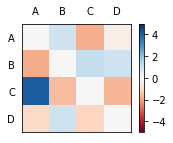

In [7]:
m.plot_norm_diff()

We can also interpret this matrix as a graph. The transitions from A to C are particularly strong in this one. Transitions from C to A happen less often than we'd expect. Those from B to D and D to B, less so.

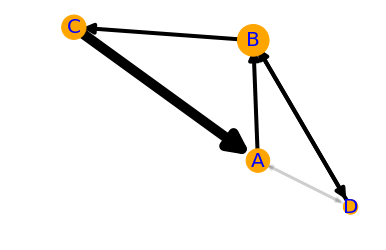

In [8]:
%matplotlib inline
m.plot_graph()

We can look at an undirected version of the graph too. It downplays non-reciprocal relationships. I'm not sure this is useful...

/home/matt/anaconda3/envs/geocomp/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


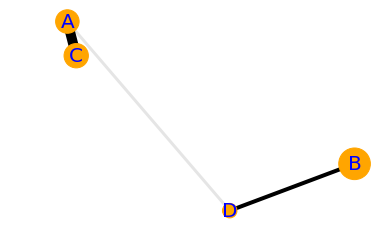

In [9]:
%matplotlib inline
m.plot_graph(directed=False)

We can generate a random succession of beds with the same transition statistics:

In [10]:
''.join(m.generate_states(n=20))

'ABABCABCBDBABCABCABC'

## Data from Matt's thesis

These are the transitions from some measured sections in my PhD thesis. They start at the bottom, so in Log 7, we start with lithofacies 1 (offshore mudstone) and pass upwards into lithofacies 3, then back into 1, then 3, and so on.

We can instantiate a `Markov_chain` object from a sequence using its `from_sequence()` method. This expects either a sequence of 'states' (numbers or letters or strings representing rock types) or a sequence of sequences of states.

In [11]:
data = {
    'log7': [1, 3, 1, 3, 5, 1, 2, 1, 3, 1, 5, 6, 1, 2, 1, 2, 1, 2, 1, 3, 5, 6, 5, 1],
    'log9': [1, 3, 1, 5, 1, 5, 3, 1, 2, 1, 2, 1, 3, 5, 1, 5, 6, 5, 6, 1, 2, 1, 5, 6, 1],
    'log11': [1, 3, 1, 2, 1, 5, 3, 1, 2, 1, 2, 1, 3, 5, 3, 5, 1, 9, 5, 5, 5, 5, 6, 1],
    'log12': [1, 5, 3, 1, 2, 1, 2, 1, 2, 1, 4, 5, 6, 1, 2, 1, 4, 5, 1, 5, 5, 5, 1, 2, 1, 8, 9, 10, 9, 5, 1],
    'log13': [1, 6, 1, 3, 1, 3, 5, 3, 6, 1, 6, 5, 3, 1, 5, 1, 2, 1, 4, 3, 5, 3, 4, 3, 5, 1, 5, 9, 11, 9, 1],
    'log14': [1, 3, 1, 5, 8, 5, 6, 1, 3, 4, 5, 3, 1, 3, 5, 1, 7, 7, 7, 1, 7, 1, 3, 8, 5, 5, 1, 5, 9, 9, 11, 9, 1],
    'log15': [1, 8, 1, 3, 5, 1, 2, 3, 6, 3, 6, 5, 2, 1, 2, 1, 8, 5, 1, 5, 9, 9, 11, 1],
    'log16': [1, 8, 1, 5, 1, 5, 5, 6, 1, 3, 5, 3, 5, 5, 5, 8, 5, 1, 9, 9, 3, 1],
    'log17': [1, 3, 8, 1, 8, 5, 1, 8, 9, 5, 10, 5, 8, 9, 10, 8, 5, 1, 8, 9, 1],
    'log18': [1, 8, 2, 1, 2, 1, 10, 8, 9, 5, 5, 1, 2, 1, 2, 9, 5, 9, 5, 8, 5, 9, 1]
}

logs = list(data.values())

m = Markov_chain.from_sequence(logs, states=range(1,12))
m.transition_counts

array([[ 0., 21., 17.,  3., 15.,  2.,  2.,  8.,  2.,  1.,  0.],
       [21.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [12.,  0.,  0.,  2., 12.,  3.,  0.,  2.,  0.,  0.,  0.],
       [ 0.,  0.,  2.,  0.,  3.,  0.,  0.,  0.,  0.,  0.,  0.],
       [19.,  1.,  9.,  0.,  0.,  9.,  0.,  4.,  5.,  1.,  0.],
       [ 9.,  0.,  1.,  0.,  4.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 3.,  1.,  0.,  0.,  7.,  0.,  0.,  0.,  5.,  0.,  0.],
       [ 4.,  0.,  1.,  0.,  6.,  0.,  0.,  0.,  0.,  2.,  3.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  2.,  1.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.]])

Let's check out the normalized difference matrix:

In [12]:
np.set_printoptions(suppress=True, precision=1, linewidth=120)
m.normalized_difference()

array([[ 0. ,  3.6,  0.9,  0.7, -1.7, -1.6,  1.4,  0.6, -1.8, -0.5, -1.1],
       [ 3.6,  0. , -1.1, -0.7, -2.2, -1.1, -0.4, -1.2, -0.4, -0.6, -0.5],
       [-0.4, -1.7,  0. ,  1.8,  1.9,  1. , -0.5,  0. , -1.4, -0.7, -0.6],
       [-1.4, -0.7,  1.8,  0. ,  2. , -0.5, -0.2, -0.5, -0.5, -0.3, -0.2],
       [-0.9, -1.8,  0.7, -1. ,  0. ,  3.5, -0.6,  0.3,  0.9,  0.2, -0.8],
       [ 1.4, -1.1, -0.6, -0.5,  0.6,  0. , -0.3, -0.9, -0.9, -0.4, -0.4],
       [ 1.4, -0.4, -0.5, -0.2, -0.6, -0.3,  0. , -0.3, -0.3, -0.2, -0.1],
       [-1.4, -0.4, -1.4, -0.5,  1.9, -0.9, -0.3,  0. ,  4.1, -0.5, -0.4],
       [-1. , -1.2, -0.7, -0.5,  1.4, -0.9, -0.3, -1. ,  0. ,  3.7,  6.8],
       [-1.3, -0.6, -0.7, -0.3,  0.2, -0.4, -0.2,  3.7,  1.6,  0. , -0.2],
       [-0.2, -0.5, -0.6, -0.2, -0.8, -0.4, -0.1, -0.4,  4.4, -0.2,  0. ]])

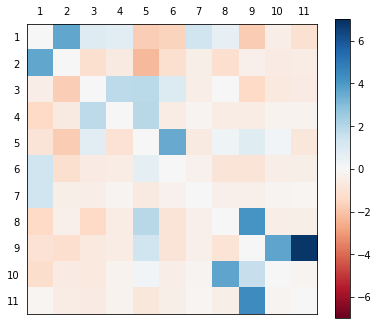

In [13]:
m.plot_norm_diff()

And the graph version. **Note you can re-run this cell to rearrange the graph.**

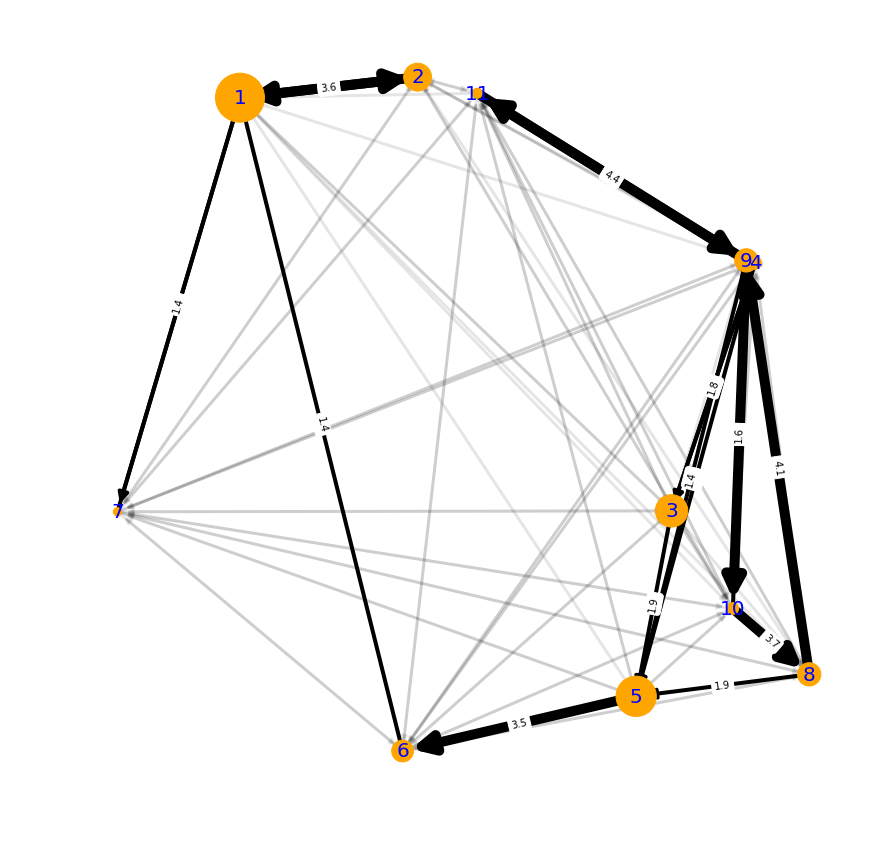

In [14]:
m.plot_graph(figsize=(15,15), max_size=2400, edge_labels=True)

## Fake data

Let's also make one from a long string of transitions:

In [15]:
data = "sssmmmlllmlmlsslsllsmmllllmssssllllssmmlllllssssssmmmmsmllllssslmslmsmmmslsllll"""

In [16]:
m = Markov_chain.from_sequence(data, include_self=True)
m

Markov_chain(78.0 transitions, states=['l' 'm' 's'])

In [17]:
m.transition_counts

array([[19.,  5.,  7.],
       [ 6.,  9.,  5.],
       [ 7.,  6., 14.]])

In [18]:
m._state_probs

array([0.4, 0.3, 0.3])

In [19]:
m.transition_freqs

array([[0.6, 0.2, 0.2],
       [0.3, 0.4, 0.2],
       [0.3, 0.2, 0.5]])

In [20]:
m.expected_freqs

array([[0. , 0.4, 0.6],
       [0.6, 0. , 0.4],
       [0.7, 0.3, 0. ]])

In [21]:
m.states

array(['l', 'm', 's'], dtype='<U1')

Conditional probabilities given a 'current' state:

In [22]:
m._conditional_probs('l')

array([0.6, 0.2, 0.2])

A random sequence generated from the Markov chain model:

In [23]:
m.generate_states(12)

['l', 'm', 'm', 's', 's', 's', 'm', 'm', 'l', 'm', 'l', 'm']

----

&copy; Agile Scientific 2019, licensed CC-BY / Apache 2.0, please share this work